<a href="https://colab.research.google.com/github/Manasa-220/Bert_LLM/blob/main/LLM_Report_22019461.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0 Introduction


Social media platforms like Reddit have become key spaces for discussing mental health issues.
By analyzing posts from mental health-related subreddits, we can better understand the prevailing sentiments
and identify posts that might indicate distress or a need for intervention. This project aims to fine-tune a
DistilBERT model to classify Reddit posts as either needing attention or general discussion based on their sentiment.
We will use the reddit_mental_health_posts dataset from Hugging Face for this analysis.

# 2.0 Methodology

In this project, we will use the DistilBERT model, a lightweight version of BERT, for sentiment classification.
The steps will include:

1. Loading and preprocessing the reddit_mental_health_posts dataset.
2. Tokenizing the text using the DistilBERT tokenizer.
3. Fine-tuning the DistilBERT model on the dataset.
4. Evaluating the model's performance on a test set.
5. Deploying the model to classify new Reddit posts.

This project uses the BERT (Bidirectional Encoder Representations from Transformers) architecture to classify health-related Reddit reviews into positive or negative sentiments. BERT, pre-trained on vast datasets, uses a multi-head attention mechanism to understand word relationships. The model includes the BERT base with an added linear layer for sequence classification, outputting logits processed with activation functions to predict sentiment. The bert-base-uncased weights, with 110 million parameters, were used for consistent text processing by converting all input to lowercase.

# 3.0 Implementation

Project Setup and Data Preparation

In [ ]:
from IPython.display import clear_output

!pip install transformers torch pandas matplotlib
!pip install pyarrow datasets
clear_output()

In [ ]:
# Import necessary libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from transformers import get_scheduler
from datasets import load_dataset
from tqdm.auto import tqdm
from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

dataset = load_dataset("solomonk/reddit_mental_health_posts", split='train')

df = pd.DataFrame(dataset)
df.to_csv('/content/drive/My Drive/reddit_health_reviews.csv')
print(df.info())

df.head(10)

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/151288 [00:00<?, ? examples/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151288 entries, 0 to 151287
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   author        151288 non-null  object 
 1   body          149679 non-null  object 
 2   created_utc   151288 non-null  object 
 3   id            151288 non-null  object 
 4   num_comments  151288 non-null  int64  
 5   score         151288 non-null  int64  
 6   subreddit     151288 non-null  object 
 7   title         151288 non-null  object 
 8   upvote_ratio  151288 non-null  float64
 9   url           151288 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 11.5+ MB
None


,author,body,created_utc,id,num_comments,score,subreddit,title,upvote_ratio,url
0,HotConversation1273,A few months ago I was accepted into this full...,2021-12-22T18:32:56.000Z,rmbjwb,1,1,ADHD,I get extremely anxious if I’m not working 24/7,1.0,https://www.reddit.com/r/ADHD/comments/rmbjwb/...
1,snorefestt,"Hey guys, I was curious if anyone else has the...",2021-12-22T18:24:25.000Z,rmbd1y,3,5,ADHD,"I can't will myself to clean my own house, but...",1.0,https://www.reddit.com/r/ADHD/comments/rmbd1y/...
2,etyf12,\n\ni have 6 exams in the next 2 weeks one of...,2021-12-22T18:22:52.000Z,rmbbvu,1,2,ADHD,i need some help,1.0,https://www.reddit.com/r/ADHD/comments/rmbbvu/...
3,GetHairOrDieTryin,Is there anyone out there that is struggling w...,2021-12-22T18:20:35.000Z,rmba1t,3,2,ADHD,Anyone up for a chat?,1.0,https://www.reddit.com/r/ADHD/comments/rmba1t/...
4,ZeroTransPat,"Whenever I get hungry, I never eat because I d...",2021-12-22T18:18:47.000Z,rmb8lm,2,1,ADHD,Figuring out what to eat sucks,1.0,https://www.reddit.com/r/ADHD/comments/rmb8lm/...
5,[deleted],[removed],2021-12-22T18:18:19.000Z,rmb88p,1,1,ADHD,Watching movies at x1.5 playback speed,1.0,https://www.reddit.com/r/ADHD/comments/rmb88p/...
6,Used_Inspection2618,I’m on 20 mg of Lexapro and 50 mg Vyvanse and ...,2021-12-22T18:15:52.000Z,rmb6f2,4,1,ADHD,Drinking while on meds?,1.0,https://www.reddit.com/r/ADHD/comments/rmb6f2/...
7,TheToastyToad,"I've recently had a big lifestyle change, with...",2021-12-22T18:13:15.000Z,rmb47u,1,2,ADHD,Using Christmas to take a break,1.0,https://www.reddit.com/r/ADHD/comments/rmb47u/...
8,Field-cave1519,"I'm a newly diagnosed 42 yr old female, who st...",2021-12-22T18:11:07.000Z,rmb2i8,1,1,ADHD,Does everyone get the euphoria feeling when th...,1.0,https://www.reddit.com/r/ADHD/comments/rmb2i8/...
9,Away_Entertainment29,TL;DR - rough time titrating on concerta for t...,2021-12-22T18:09:50.000Z,rmb1ib,1,1,ADHD,Xaggatin: zoned out and angry,1.0,https://www.reddit.com/r/ADHD/comments/rmb1ib/...


In [ ]:
df.columns

Index(['author', 'body', 'created_utc', 'id', 'num_comments', 'score', 'subreddit', 'title', 'upvote_ratio', 'url'], dtype='object')

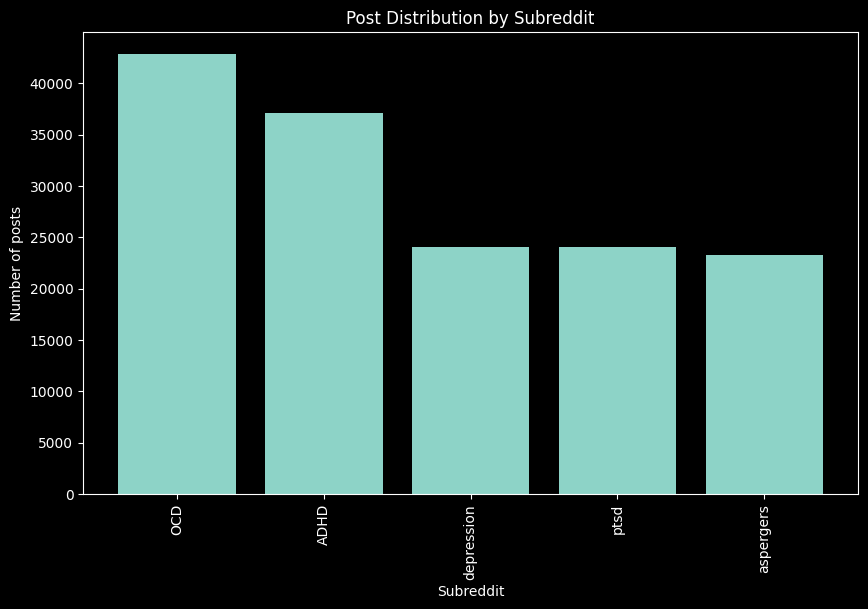

Posts from ADHD subreddit
Regarding ADHD as a learning disability. One thing scares me to no end. I'm great at math, I'm great at language, I'm great at history, psychology, sociology and to in \*some\* aspects also science. It feels like I got every necessary scale filled to the brim already, I just learn concepts quickly. I absolutely hate school though and can ONLY perform well if I'm interested. Spoiler alert: It's rare, very very rare. I'm not an intellectualist (someone who seeks knowledge for the sake of enjoyment) for school in the least and have just recently learnt to force myself to pass by using medication (with years of practicing through copious trials and error, different lifestyles, mindsets, overcompensations etc).   


And here it comes, the obvious. One thing I can't perform well not on, no matter how interested and engaged and hyperfocused I am, no matter my medication. Is programming. One of my courses is in programming and I'm afraid if I don't manage to struggle 

In [ ]:
#  distribution of posts by subreddit
label_count = df['subreddit'].value_counts().to_dict()
plt.style.use("dark_background")
plt.figure(figsize=(10, 6))
plt.bar(label_count.keys(), label_count.values())
plt.xlabel('Subreddit')
plt.ylabel('Number of posts')
plt.title('Post Distribution by Subreddit')
plt.xticks(rotation=90)
plt.show()

subreddit_example = df[df['subreddit'] == 'ADHD']
print(f"Posts from {subreddit_example['subreddit'].iloc[0]} subreddit")
for _, row in subreddit_example.sample(5).iterrows():
    print(row['body'])
    print(' ')

# 4.0 Training and Fine-Tuning

We'll preprocess the data, tokenize it using the DistilBERT tokenizer, and then fine-tune the model.

In [ ]:
#  TextBlob
!pip install textblob
!python -m textblob.download_corpora
clear_output()


In [ ]:
from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 2
    elif analysis.sentiment.polarity == 0:
        return 1
    else:
        return 0

df = df.dropna(subset=['body'])

df['label'] = df['body'].apply(get_sentiment)

print("Sample labels:", df['label'].head())
print("Label data type:", df['label'].dtype)
print(df[['body', 'label']].head(10))

Sample labels: 0    0
1    2
2    0
3    0
4    0
Name: label, dtype: int64
Label data type: int64
                                                body  label
0  A few months ago I was accepted into this full...      0
1  Hey guys, I was curious if anyone else has the...      2
2   \n\ni have 6 exams in the next 2 weeks one of...      0
3  Is there anyone out there that is struggling w...      0
4  Whenever I get hungry, I never eat because I d...      0
5                                          [removed]      1
6  I’m on 20 mg of Lexapro and 50 mg Vyvanse and ...      1
7  I've recently had a big lifestyle change, with...      2
8  I'm a newly diagnosed 42 yr old female, who st...      2
9  TL;DR - rough time titrating on concerta for t...      0


In [ ]:
class RedditDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        post = self.df.iloc[index]['body']
        label = self.df.iloc[index]['label']
        encoding = self.tokenizer.encode_plus(
            post,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'post_text': post,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_len = 512

train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
train_dataset = RedditDataset(train_df, tokenizer, max_len)
val_dataset = RedditDataset(val_df, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, AdamW, get_scheduler

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 1
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in tqdm(data_loader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for data in tqdm(data_loader):
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['labels'].to(device)

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)


In [ ]:
print(df['label'].unique())

[0 2 1]


In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device, lr_scheduler)
    print(f"Train loss {train_loss} accuracy {train_acc}")

    val_acc, val_loss = eval_model(model, val_loader, device)
    print(f"Validation loss {val_loss} accuracy {val_acc}")


Epoch 1/1


  0%|          | 0/8420 [00:00<?, ?it/s]

Train loss 0.17006107814498844 accuracy 0.9296197044042431


  0%|          | 0/936 [00:00<?, ?it/s]

Validation loss 0.11378537154267443 accuracy 0.9569080705505076


Model Evaluation

In [ ]:
## Evaluation
print("Evaluating model on validation set...")
val_acc, val_loss = eval_model(model, val_loader, device)
print(f"Validation Accuracy: {val_acc}, Validation Loss: {val_loss}")

Evaluating model on validation set...


  0%|          | 0/936 [00:00<?, ?it/s]

Validation Accuracy: 0.9569080705505076, Validation Loss: 0.11378537154267443


The training dataset consisted of 50% of the total health-related Reddit reviews, which was further split 9:1, with 10% of the training set reserved for validation. The test dataset comprised 10% of the total reviews. The classes in the dataset are balanced, and the bert-base-uncased tokenizer was used to convert all text to lowercase before training. Hyperparameter tuning was conducted optimizing parameters learning rate, with accuracy as the evaluation metric.

After several trials, the model with the highest validation accuracy was (95.69%).

# 5.0 Deployment
We deploy the fine-tuned model with ipywidgets This interface allows users to input a text review and receive a sentiment prediction from the model.

In [ ]:
## Deployment with UI

from transformers import pipeline

model.eval()
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

def classify_post(post):
    result = classifier(post)
    return result

print("Example of classifying a new post:")
new_post = "I am feeling really down today. I don't know how to cope with my anxiety."
print(classify_post(new_post))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Example of classifying a new post:
[{'label': 'LABEL_0', 'score': 0.8480876684188843}]


In [ ]:
import ipywidgets as widgets
from IPython.display import display

def on_submit(change):
    with out:
        clear_output(wait=True)
        print("Classifying the post...")
        print(classify_post(change.new))

text = widgets.Text(description="New Post:")
text.observe(on_submit, names='value')

out = widgets.Output()
display(text, out)


Text(value='', description='New Post:')

Output()

The deployment was done with ipywidgets library for UI with a text box. When a user hits enter, the input is tokenized using the bert-base-uncased tokenizer. The tokenized input is then passed to the trained model, which outputs logits. The predicted class is determined using np.argmax to select the class with the highest probability, and the corresponding probability is also returned.

# 6.0 Conclusion
By fine-tuning the DistilBERT model on the `reddit_mental_health_posts` dataset, this project successfully classified posts to show whether they need attention or are general discussions. The project demonstrates the potential of using machine learning for mental health monitoring on social media platforms.
